# Code to identify cut, scale and offset factors to splice curves
M.R. Fitzsimmons and T.R. Charlton (July 16, 2020)

To acknowledge this work please cite: 10.5281/zenodo.3968838

Version 3.0

This code requires some care on the part of the user. It's intended to estimate scale factors that make overlapping
Q regions have the same reflectivities.  There's is no accounting for Q-offsets arising from two theta (scattering angle) errors. The 
user has options to closely explore overlap regions, cut Q-points from end and beginning of run-pairs. The routine
will apply a scale factor that is a waited average of Q-points in common between the run-pairs. Errors on the
reflectivities are scaled as well. The individual scaled files are written with an '_red' label.  These can be
loaded into GenX as separate instruments and the scale factors and two theta offsets optimally calculated.  Finally,
a concatonated Q-sorted file is also written which has all the data (in one file).

Weighted averages of the overlapping regions are used to estimate the scale factors.

All negative reflectivities are replaced with the smallest positive reflectivity and the error for those replacements
is set equal to 1, so that in a refinement they do not influence the fitting.

2/20/21
Execute cuts before autoscale.

26.02.2021 Made changes to colors displayed on final two figures.

12.04.2021 Fixed dx0 in place of dx1 error; more robust overlap defition

27.07.2021 Specified np.float32

10.03.2022 Added a toggle DoDelete = True to delete data for all spin states if any R is negative.

29.05.2022 Add a toggle FixQ to fix the min and max values of Q if desired.

27.11.2022 Add section to check for subdirectory structure, check for overlap and set a value if none

02.12.2022 Changed to non-zero, documented that code assumes q's for different x-section in same file are identical

# Import libraries, physical constants, and define functions. 

In [15]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from itertools import cycle
import numpy as np
import scipy.optimize
from scipy.optimize import curve_fit
import scipy.constants 
import copy

# get physical constants from scipy library
Pi = scipy.constants.pi
hbar = scipy.constants.hbar
m_n = scipy.constants.neutron_mass
mu_n = np.abs(scipy.constants.physical_constants['neutron mag. mom.'][0]) # absolute value of the neutron magnetic moment J/T

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_line(x, a, b, c, d, e):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x


/Users/pookie
Current working directory: /Users/pookie


## User selects Q-binned data files to splice (User input here)

Splicing involves identifying regions of Q shared between two Q-binned files, calculating a multiplicative constant that shifts one relative to the other along the reflectivity axis.

There is no splicing along the Q axis.  We assume that the measured Q values are correct (either as-measured or through a shift using QFactor in Module3).

Define a list of strings representing the run numbers as run_numbers.

Define a list of number pairs that represent the number of Q-measurements to exclude at the beginning and end of each file as big_cut.  The head and tails tend to be affected by chopper shadow and jitter.

Define a string of 'Upper' 'Middle' or 'Bottom' for the position of the sample in the detector view as Sample.

Typically, the strategy for splicing is either not to (and let GenX do the scaling for you) or if a single reflectivity curve is desired to start with a pair of files at the smallest Q, get these to splice together reasonably (by choosing values for big_cut), and then adding the next measurement and so forth until finished.

Note, the list of run numbers need not be increasing or even sequential, however, they must be listed with increasing Q-ranges.

In [16]:
##############
# User input below

# Define directory path.
directory_path = cwd_path+r'/JNUpdates/27527/'

# Choose the run numbers of the files to splice, Q-measurements to exclude on head and tail, and Sample position (Upper, Middle or Bottom)

run_numbers, big_cut, Sample = ['38970','38971','38972','38973','38974'],[[15,2],[2,1],[1,1],[1,1],[1,1]], 'Upper'

# User input above
##############

## User selects processing options

DoDelete if true will identify a Q with a negative reflectivity for any spin state and delete measurements with this Q for all spin states.

dTolerance is the variation in the Q values identified for regions of overlap. 0.0001 is recommended.

rel_dqz is the relative size of the Q-bins in dQ/Q.  2-4% is recommended.

If FixQ is true then the minimum and maximum values of Q are defined by the user.

In [17]:
DoDelete = True 

dTolerance = 0.0001 

rel_dqz = 0.02 # relative Qz bin width
rel_dqz = 0.04 # relative Qz bin width

FixQ = True
FixQ = False

if FixQ:
    QzMin = 0.008
    QzMax = 0.160
#     QzMin = 8e-3
#     QzMax = 1.e-1
    print('Fixed Q limits selected: ',QzMin,QzMax)


## Check if directory exists.

Create subdirectory structure if necessary.

Exit on errors.

In [18]:
# Test if directory structure in place

SubDirectoryQ = 'QBinned/'+Sample+'/'
path = directory_path+SubDirectoryQ
isdir = os.path.isdir(path)
if not isdir:
    print('Subdirectory not found.%s'%path)
    raise SystemExit('Files not found, stopping.')
else:
    print('Subdirectory for Q-binned data found at %s'%path)
    

Subdirectory for Q-binned data found at /Users/pookie/JNUpdates/27527/QBinned/Upper/


## Get the data

This cell will read the files and store the data in an array.

If a file does not exist (of at least one cross-section), the code terminates with an error.

The order of the arrays is:
    
1 output_oo = Result_File_1_Base+'_pp.out' # The variable _xx corresponds to the orientation of moment wrt B (or unpolarized beam).

2 output_pp = Result_File_1_Base+'_mm.out' # The variable _yy in the string corresponds to the spin of the moment,

3 output_po = Result_File_1_Base+'_mp.out' # which is opposite to the moment.

4 output_op = Result_File_1_Base+'_pm.out' # These files are compatible with GenX reflectivity analysis program https://genx.sourceforge.io/.


In [19]:
files = [path+run_numbers[i] for i in range(len(run_numbers))]
layer_dict = {} # we will store arrays of potentially different sizes in the dictionary addressd by run_numbers

for j in range(len(files)):
    print(files[j])
    active_spin_states = [0,0,0,0]
    try:
        file_up = open(files[j]+'_pp.out','r')
        data_up = file_up.readlines()
        file_up.close()
        for i in range(len(data_up)):
            data_up[i] = np.fromstring( data_up[i], dtype=np.float32, sep=' ' )
        s_up = np.zeros((len(data_up),4))
        for i in range(len(data_up)):
            s_up[i,:] = data_up[i]
        active_spin_states[0] = 1
        print('Found _pp data.')
    except:
        s_up = [-1]
        print('No _pp data found.')
    try:
        file_dw = open(files[j]+'_mm.out','r')
        data_dw = file_dw.readlines()
        file_dw.close()
        for i in range(len(data_dw)):
            data_dw[i] = np.fromstring( data_dw[i], dtype=np.float32, sep=' ' )
        s_dw = np.zeros((len(data_dw),4))
        for i in range(len(data_dw)):
            s_dw[i,:] = data_dw[i]
        active_spin_states[1] = 1
        print('Found _mm data.')
    except:
        s_dw = [-1]
        print('No _mm data found.')
    try:
        file_po = open(files[j]+'_mp.out','r')
        data_po = file_po.readlines()
        file_po.close()
        for i in range(len(data_po)):
            data_po[i] = np.fromstring( data_po[i], dtype=np.float32, sep=' ' )
        s_po = np.zeros((len(data_po),4))
        for i in range(len(data_po)):
            s_po[i,:] = data_po[i]
        active_spin_states[2] = 1
        print('Found _mp data.')
    except:
        s_po = [-1]
        print('No _mp data found.')
    try:
        file_op = open(files[j]+'_pm.out','r')
        data_op = file_op.readlines()
        file_op.close()
        for i in range(len(data_op)):
            data_op[i] = np.fromstring( data_op[i], dtype=np.float32, sep=' ' )
        s_op = np.zeros((len(data_op),4))
        for i in range(len(data_op)):
            s_op[i,:] = data_op[i]
        active_spin_states[3] = 1
        print('Found _pm data.')
    except:
        s_op = [-1]
        print('No _pm data found.')
        
    if np.sum(active_spin_states) == 0: # no file of any cross-section found.
        print('Q-binned file not found.%s'%files[j])
        raise SystemExit('Files not found, stopping.')
            
    n = np.max([len(s_up),len(s_dw),len(s_po),len(s_op)])
    all_xs = np.zeros((n,4,4),dtype = np.float32)
    if active_spin_states[0]==1: 
        all_xs[:,:,0] = s_up
    if active_spin_states[1]==1: 
        all_xs[:,:,1] = s_dw
    if active_spin_states[2]==1: 
        all_xs[:,:,2] = s_po
    if active_spin_states[3]==1: 
        all_xs[:,:,3] = s_op

    layer_dict[run_numbers[j]] = all_xs


/Users/pookie/JNUpdates/27527/QBinned/Upper/38970
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/pookie/JNUpdates/27527/QBinned/Upper/38971
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/pookie/JNUpdates/27527/QBinned/Upper/38972
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/pookie/JNUpdates/27527/QBinned/Upper/38973
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/pookie/JNUpdates/27527/QBinned/Upper/38974
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.


## Search for negative reflectivity in any spin state and delete data for all spin states with the same value of Q

In [20]:
if DoDelete:
    for j in range(len(files)):
        x = layer_dict[run_numbers[j]]
        jdx = np.nonzero(x[:,1,:]<0) # find negative R
        if len(jdx) > 0:
            hdx = np.unique(jdx[:][0]) # find unique Q values with negative R
            a = np.delete(x,hdx,axis=0) # delete Q corresponding to a negative R from all spin states
            layer_dict[run_numbers[j]] = a
            print('Negative reflectivity observed: %s for run number %s'%(len(jdx),run_numbers[j]))

Negative reflectivity observed: 2 for run number 38970
Negative reflectivity observed: 2 for run number 38971
Negative reflectivity observed: 2 for run number 38972
Negative reflectivity observed: 2 for run number 38973
Negative reflectivity observed: 2 for run number 38974


## Plot the data.

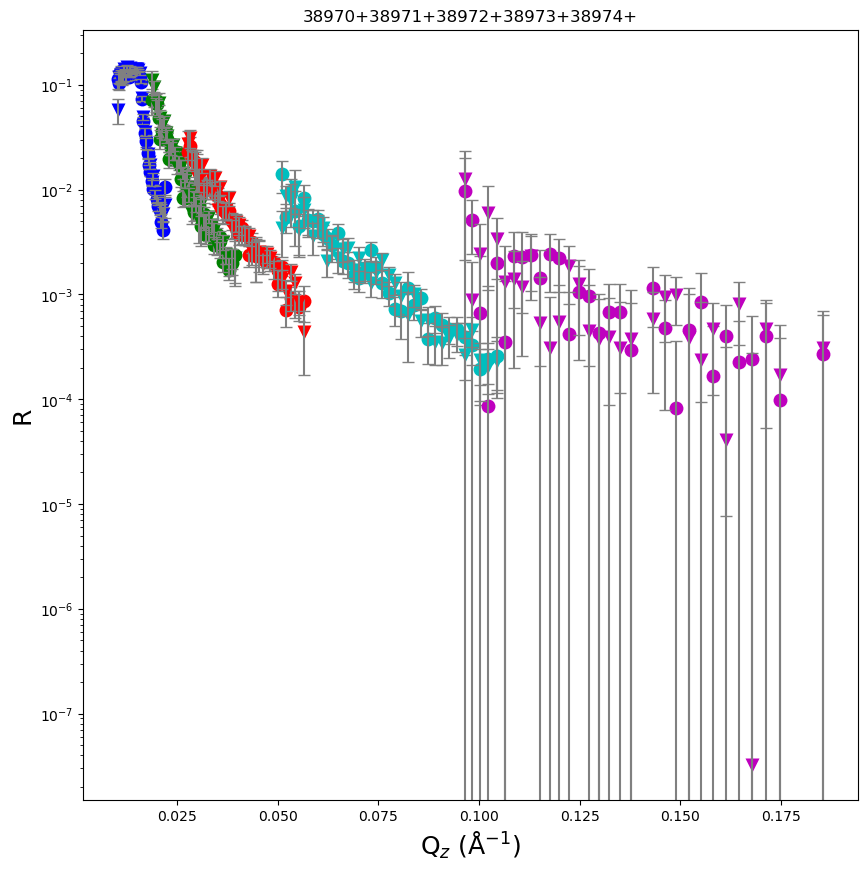

In [21]:
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
plt.ylabel('R',fontsize=18)
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = layer_dict[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='gray')
plt.show()


## Cut the data.

This cell removes Q-measurements from the head and tail per big_cut

In [22]:
for i in range(len(files)):
    s0 = big_cut[i][0]
    n=layer_dict[run_numbers[i]].shape[0]
    s1 = n-big_cut[i][1]
    x = layer_dict[run_numbers[i]]
    x = x[s0:s1,:,:]
    layer_dict[run_numbers[i]] = x

    

## Replot the data.

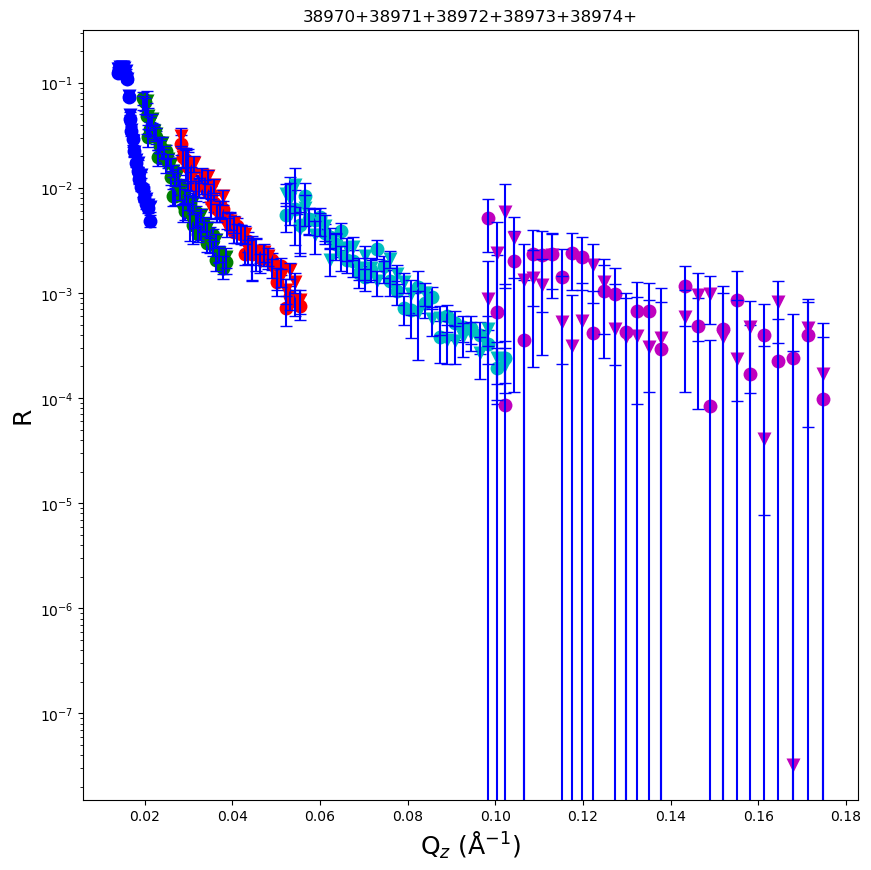

In [23]:
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
plt.ylabel('R',fontsize=18)
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = layer_dict[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()


## Autoscale

User may need to re-execute this cell to reset the data from study in the following cells.

If no overlap is found between sequential files a warning is returned and a value that equates the Q-max of the first file to the Q-min of the second file is used.

Code assumes that the q's are the same for each spin cross-section. In other words every cross-section in a run file has the same list of q's.

In [24]:
scaled = copy.deepcopy(layer_dict)

idx = np.nonzero(active_spin_states)[0]

# calculate the scale factors for each pair of files
s_factor = np.zeros(len(files)-1, dtype=np.float32)
for i in range(len(files)-1):
    x0 = scaled[run_numbers[i]]
    q0 = x0[:,0,idx][:,0] # these are the q's in the ith run file, and we pick only one set
    qmax0 = np.max(q0)
    qmin0 = np.min(q0)
    
    x1 = scaled[run_numbers[i+1]]
    q1 = x1[:,0,idx][:,0] # these are the q's in the i+1th run file, and we pick only one set
    qmax1 = np.max(q1)
    qmin1 = np.min(q1)
    
    if qmin1 <= qmax0:    
        over0 = np.nonzero(q0 >= qmin1-dTolerance)[0]
        over1 = np.nonzero(q1 <= qmax0+dTolerance)[0]

        n0 = len(over0)
        dx0 = np.zeros(n0,dtype=np.float32)
        if n0 == 1:
            dx0[0] = q0[over0[0]]-q0[over0[0]-1]
        elif n0 == 2:
            dx0[0] = q0[over0[1]]-q0[over0[0]]
            dx0[1] = dx0[0]
        else:
            for j in range(n0-1):
                dx0[j] = (q0[over0[j]+1]-q0[over0[j]-1])/2
            dx0[n0-1] = dx0[n0-2]

        n1 = len(over1)
        dx1 = np.zeros(n1,dtype=np.float32)
        if n1 == 1:
            dx1[0] = q1[over1[0]+1]-q1[over1[0]]
        elif n1 == 2:
            dx1[0] = q1[over1[1]]-q1[over1[0]]
            dx1[1] = dx1[0]
        else:        
            for j in range(n1-2):
                dx1[j+1] = (q1[over1[j+1]+1]-q1[over1[j+1]-1])/2
            dx1[n1-1] = q1[over1[n1-1]]-q1[over1[n1-2]]
            dx1[0] = dx1[1]

        if active_spin_states[0]==1 & active_spin_states[1]==1:     # use both up and dw   
            g0 = np.append(x0[over0,1,0],x0[over0,1,1])*np.append(dx0,dx0) # concatonate both spin states, integrated R
            h0 = np.append(x0[over0,2,0],x0[over0,2,1])*np.append(dx0,dx0) # integrated sigmaR
            f0 = (x0[over0,1,0]+x0[over0,1,1])*dx0
            e0 = (x0[over0,2,0]+x0[over0,2,1])*dx0
            g1 = np.append(x1[over1,1,0],x1[over1,1,1])*np.append(dx1,dx1)
            h1 = np.append(x1[over1,2,0],x1[over1,2,1])*np.append(dx1,dx1)
            f1 = (x1[over1,1,0]+x1[over1,1,1])*dx1
            e1 = (x1[over1,2,0]+x1[over1,2,1])*dx1
        else:
            g0 = x0[over0,1,idx]*dx0 # identical to case below cause no states to concatonate, reqd for transparency
            h0 = x0[over0,2,idx]*dx0
            f0 = x0[over0,1,idx]*dx0
            e0 = x0[over0,2,idx]*dx0
            g1 = x1[over1,1,idx]*dx1
            h1 = x1[over1,2,idx]*dx1
            f1 = x1[over1,1,idx]*dx1
            e1 = x1[over1,2,idx]*dx1
        a0 = np.sum(f0)
        b0 = np.average(f0,weights=1/e0)
        c0 = np.average(g0,weights=1/h0)
        a1 = np.sum(f1)
        b1 = np.average(f1,weights=1/e1)
        c1 = np.average(g1,weights=1/h1)
    #    s_factor[i] = np.sum(a0/a1) #apply to file1 to scale to file0, sums only
    #    s_factor[i] = np.sum(b0/b1) #apply to file1 to scale to file0, weighted aveage of sums
        s_factor[i] = np.sum(c0/c1) #apply to file1 to scale to file0, weighted average of each distribution
        print('\t\t\tRun #%s\tRun #%s\tRatio'%(run_numbers[i],run_numbers[i+1]))
        print('Integral sum: \t\t%.2E\t%.2E\t%.2E'%(a0,a1,np.sum(a0/a1)))
        print('Integral average: \t%.2E\t%.2E\t%.2E'%(b0,b1,np.sum(b0/b1)))
        print('Weighted average: \t%.2E\t%.2E\t%.2E'%(c0,c1,np.sum(c0/c1)))
    else:        
        g0 = np.sum(x0[-1,1,idx])
        g1 = np.sum(x1[0,1,idx])
        s_factor[i] = g0/g1
        print('WARNING: No overlap found. Using: %.2f'%s_factor[i])            
        print('Q-range of Run #%s: %.3e %.3e'%(run_numbers[i],qmin0,qmax0))
        print('Q-range of Run #%s: %.3e %.3e'%(run_numbers[i+1],qmin1,qmax1))

# the nth s_factor is the product of it and the ones before.
for i in range(len(files)-2,0,-1):
    for j in range(i-1,-1,-1):
        s_factor[i] = s_factor[i]*s_factor[j]
print('Ratio factors: ',s_factor)
# apply scale
for i in range(1,len(files)):
    x = scaled[run_numbers[i]]
    for j in range(4):
        x[:,1,j] = x[:,1,j] * s_factor[i-1]
        x[:,2,j] = x[:,2,j] * s_factor[i-1]    
    
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
plt.ylabel('R',fontsize=18)
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = scaled[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()

# Finally make a working copy of scaled
working = copy.deepcopy(scaled)

			Run #38970	Run #38971	Ratio
Integral sum: 		2.25E-05	1.83E-04	1.23E-01
Integral average: 	5.63E-06	4.47E-05	1.26E-01
Weighted average: 	2.80E-06	2.20E-05	1.27E-01
			Run #38971	Run #38972	Ratio
Integral sum: 		9.04E-05	2.52E-04	3.59E-01
Integral average: 	5.05E-06	1.37E-05	3.67E-01
Weighted average: 	2.50E-06	6.83E-06	3.66E-01
			Run #38972	Run #38973	Ratio
Integral sum: 		8.57E-06	6.08E-05	1.41E-01
Integral average: 	2.12E-06	1.44E-05	1.48E-01
Weighted average: 	1.04E-06	7.08E-06	1.47E-01
			Run #38973	Run #38974	Ratio
Integral sum: 		3.28E-06	3.02E-05	1.09E-01
Integral average: 	1.06E-06	9.84E-06	1.08E-01
Weighted average: 	5.27E-07	3.20E-06	1.65E-01
Ratio factors:  [0.12719837 0.04659809 0.0068437  0.00112661]


## Normalize maximum to unit reflectivity and write spliced files.

The files written in this cell are not evenly Q-binned.

Suitable for import into GenX, but must use the "slow" Q-resolution convolution method.

The '_red' files can be imported as files and the scaling factors refined by GenX. 

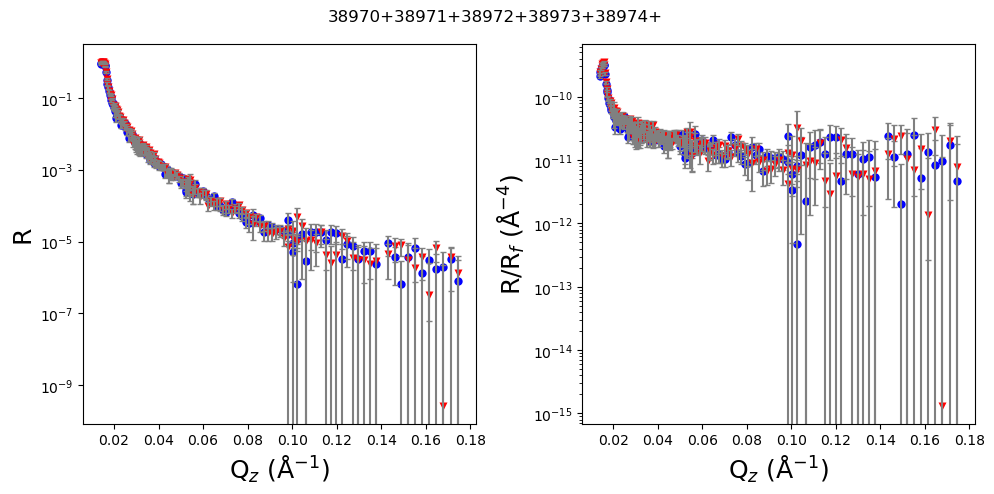

In [25]:
# find the maximum reflectivity

col = ['b','r','g','k']

rmax = -1.
rmin = 1.e20
for j in range(len(files)):
    x = scaled[run_numbers[j]]
    rmax = np.max([rmax,np.max(x[:,1,:])])
    rmin = np.min([rmin,np.min(np.abs(x[:,1,0]))])
# use rmax to scale all files so that the max reflectivity is 1 and scale the errors.
# will replace -'ve values of R with rmin and assign error bar of 1 to them.

# write the individual scaled files
for j in range(len(files)):
    x = scaled[run_numbers[j]]
    x[:,1,:] = x[:,1,:]/rmax # this performs the scaling to the critical edge
    x[:,2,:] = x[:,2,:]/rmax
    if active_spin_states[0]==1:
        fault = np.argwhere(x[:,1,0]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,0] = rmin/rmax
        x[fault_idx,2,0] = 1./rmax        
        file_output = open(files[j]+'_red_pp.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,0],x[i,1,0],x[i,2,0],x[i,3,0])
            file_output.write(row)
        file_output.close()
    if active_spin_states[1]==1:
        fault = np.argwhere(x[:,1,1]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,1] = rmin/rmax
        x[fault_idx,2,1] = 1./rmax        
        file_output = open(files[j]+'_red_mm.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,1],x[i,1,1],x[i,2,1],x[i,3,1])
            file_output.write(row)
        file_output.close()
    if active_spin_states[2]==1:
        fault = np.argwhere(x[:,1,2]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,2] = rmin/rmax
        x[fault_idx,2,2] = 1./rmax        
        file_output = open(files[j]+'_red_mp.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,2],x[i,1,2],x[i,2,2],x[i,3,2])
            file_output.write(row)
        file_output.close()
    if active_spin_states[3]==1:
        fault = np.argwhere(x[:,1,3]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,3] = rmin/rmax
        x[fault_idx,2,3] = 1./rmax        
        file_output = open(files[j]+'_red_pm.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,3],x[i,1,3],x[i,2,3],x[i,3,3])
            file_output.write(row)
        file_output.close()
    
# create the concatonated data set
x = scaled[run_numbers[0]]
s = copy.deepcopy(x)
for j in range(len(files)-1):
    s = np.append(s,scaled[run_numbers[j+1]],0)
idx2 = np.argsort(s[:,0,0]) # sort by ascending q
s_sort = s[idx2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
ax1.set_ylabel('R',fontsize=18)
ax1.set_yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = s_sort[:,0,j]
        h = s_sort[:,1,j]
        e = s_sort[:,2,j]
        ax1.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[j], markeredgecolor='None', markersize=6)
        ax1.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')

ax2.set_xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
ax2.set_ylabel('R/R$_{f}$ ($\mathrm{\AA}$$^{-4}$)',fontsize=18)
ax2.set_yscale('log')
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = s_sort[:,0,j]
        h = s_sort[:,1,j]/(16*np.pi**2/q**4)
        e = s_sort[:,2,j]/(16*np.pi**2/q**4)
        ax2.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[j], markeredgecolor='None', markersize=6)
        ax2.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')

fig.suptitle(title)
plt.tight_layout()
plt.show()


# write the concatonated files
if active_spin_states[0]==1:
    file_output = open(path+title+'_pp.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,0],s_sort[i,1,0],s_sort[i,2,0],s_sort[i,3,0])
        file_output.write(row)
    file_output.close()
if active_spin_states[1]==1:
    file_output = open(path+title+'_mm.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,1],s_sort[i,1,1],s_sort[i,2,1],s_sort[i,3,1])
        file_output.write(row)
    file_output.close()
if active_spin_states[2]==1:
    file_output = open(path+title+'_mp.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,2],s_sort[i,1,2],s_sort[i,2,2],s_sort[i,3,2])
        file_output.write(row)
    file_output.close()
if active_spin_states[3]==1:
    file_output = open(path+title+'_pm.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,3],s_sort[i,1,3],s_sort[i,2,3],s_sort[i,3,3])
        file_output.write(row)
    file_output.close()

if active_spin_states[0]==1 and active_spin_states[1]==1:
    file_output = open(path+title+'_sa.out','w')
    SA = np.zeros(len(s_sort), dtype=np.float32)
    DeltaSA = np.zeros(len(s_sort), dtype=np.float32)
    for i in range(len(s_sort)):
        A = s_sort[i,1,0] - s_sort[i,1,1]
        B = s_sort[i,1,0] + s_sort[i,1,1]
        DeltaA = np.sqrt(s_sort[i,2,0]**2 + s_sort[i,2,1]**2)
        if B != 0 and A !=0:
            SA[i] = A / B
            DeltaSA[i] = np.abs(SA[i]) * np.sqrt((DeltaA/A)**2 + (DeltaA/B)**2)
        else:
            SA[i] = 0.
            DeltaSA[i] = 0.
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,0],SA[i],DeltaSA[i],s_sort[i,3,0])
        file_output.write(row)
    file_output.close()

    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
    plt.ylabel('Spin Asymmetry')
    plt.yscale('linear')
#    plt.ylim(-0.15,.15)
    plt.ylim(-1,1)
    title=''
    for i in range(len(files)):
        title = title+run_numbers[i]+'+'
    plt.title(title)
    q = s_sort[:,0,0]
    h = SA
    e = DeltaSA
#    ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[0], markeredgecolor='None', markersize=6)
    ax.plot(q,h, 'bo', linestyle='None', markersize=6)
    ax.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')
    plt.show()
    



## Make Qbins

Now construct Q bins that are equal relative size per rel_dqz.

In [26]:
if not FixQ:
    QzMax = np.max(s_sort[:,0,idx])
    QzMin = np.min(s_sort[:,0,idx])
    
print('Value of FixQ: %s, range of Qz: %.3f %.3f'%(FixQ,QzMin,QzMax))
# Bin so as to keep resolution in Qz bins constant.
p = int(np.log(QzMax/QzMin)/np.log(1+rel_dqz)+1)+1
qbins = np.zeros(p, dtype=np.float32)

for i in range(p):
    qbins[i]=(1+rel_dqz)**i*QzMin # qz values for start of each bin
    
plt.figure(figsize = (10,10))
plt.title('Value of Qz-bin beginning boundary for dQ$_z$/Q$_z$ = %s'%rel_dqz, fontsize=20)
plt.xlabel('Bin number', fontsize=18)
plt.ylabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)', fontsize=18)
plt.plot(qbins,'ro')
plt.show()


Value of FixQ: False, range of Qz: 0.014 0.175


## Rebin the reflectivity per the Q-bin steps and write the results. 

Suitable for import into Genx

File written tagged with '_rebin'

In [27]:
re_sort = np.zeros((p,4,4), dtype=np.float32)
for i in range(4):
    re_sort[:,0,i] = qbins
    re_sort[:,3,i] = qbins*rel_dqz

# Find the argument of Qbins that represents a Qz most closely matching the original data
NoldQz = len(s_sort[:,0,idx])
ArgMap = np.zeros(NoldQz, dtype=np.int16)
for i in range(NoldQz):
    Temp = np.nonzero(s_sort[i,0,0]>=qbins)[0]
    if len(Temp) > 0:
        ArgMap[i] = max(Temp)
    
for i in range(p):
    x = np.nonzero(ArgMap == i)[0]
    if len(x) != 0:
        for j in range(4):
            if active_spin_states[j]==1:
                re_sort[i,1,j] = np.average(s_sort[x,1,j], weights=1/s_sort[x,2,j])
                re_sort[i,2,j] = np.sqrt(np.sum(s_sort[x,2,j]**2))/len(x)

re_sort = re_sort[0:p-1,:,:]
                
# write the concatonated files
if active_spin_states[0]==1:
    file_output = open(path+title+'_pp_rebin.out','w')
    for i in range(len(re_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(re_sort[i,0,0],re_sort[i,1,0],re_sort[i,2,0],re_sort[i,3,0])
        file_output.write(row)
    file_output.close()
if active_spin_states[1]==1:
    file_output = open(path+title+'_mm_rebin.out','w')
    for i in range(len(re_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(re_sort[i,0,1],re_sort[i,1,1],re_sort[i,2,1],re_sort[i,3,1])
        file_output.write(row)
    file_output.close()
if active_spin_states[2]==1:
    file_output = open(path+title+'_mp_rebin.out','w')
    for i in range(len(re_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(re_sort[i,0,2],re_sort[i,1,2],re_sort[i,2,2],re_sort[i,3,2])
        file_output.write(row)
    file_output.close()
if active_spin_states[3]==1:
    file_output = open(path+title+'_pm_rebin.out','w')
    for i in range(len(re_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(re_sort[i,0,3],re_sort[i,1,3],re_sort[i,2,3],re_sort[i,3,3])
        file_output.write(row)
    file_output.close()

SAFlag = False
if active_spin_states[0]==1 and active_spin_states[1]==1:
    SAFlag = True
    SA = np.zeros(len(re_sort), dtype=np.float32)
    DeltaSA = np.zeros(len(re_sort), dtype=np.float32)
    file_output = open(path+title+'_sa_rebin.out','w')
    for i in range(len(re_sort)):
        A = re_sort[i,1,0] - re_sort[i,1,1]
        B = re_sort[i,1,0] + re_sort[i,1,1]
        DeltaA = np.sqrt(re_sort[i,2,0]**2 + re_sort[i,2,1]**2)
        if B != 0:
            SA[i] = A / B
            DeltaSA[i] = np.abs(SA[i]) * np.sqrt((DeltaA/A)**2 + (DeltaA/B)**2)
        else:
            SA[i] = 0.
            DeltaSA[i] = 0.
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(re_sort[i,0,0],SA[i],DeltaSA[i],re_sort[i,3,0])
        file_output.write(row)
    file_output.close()

## Show results

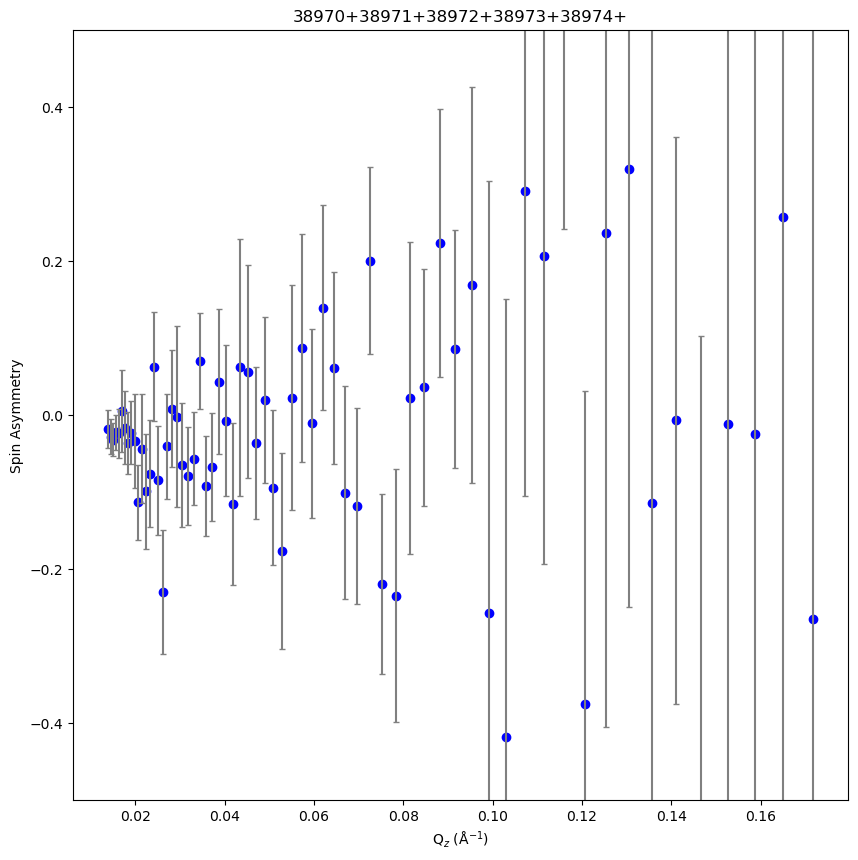

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
ax1.set_ylabel('R',fontsize=18)
ax1.set_yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = re_sort[:,0,j]
        h = re_sort[:,1,j]
        e = re_sort[:,2,j]
        ax1.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[j], markeredgecolor='None', markersize=6)
        ax1.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')


#ax2.set_xlabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
ax2.set_xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)',fontsize=18)
ax2.set_ylabel('R/R$_{f}$ ($\mathrm{\AA}$$^{-4}$)',fontsize=18)
ax2.set_yscale('log')
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = re_sort[:,0,j]
        h = re_sort[:,1,j]/(16*np.pi**2/q**4)
        e = re_sort[:,2,j]/(16*np.pi**2/q**4)
        ax2.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[j], markeredgecolor='None', markersize=6)
        ax2.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')

fig.suptitle(title)
plt.tight_layout()
plt.show()

if SAFlag:
    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlabel('Q$_z$ ($\mathrm{\AA}$$^{-1}$)')
    plt.ylabel('Spin Asymmetry')
    plt.yscale('linear')
    plt.ylim(-0.5,.5)
#    plt.ylim(-1,1)
    title=''
    for i in range(len(files)):
        title = title+run_numbers[i]+'+'
    plt.title(title)
    q = re_sort[:,0,0]
    h = SA
    e = DeltaSA
#    ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col[0], markeredgecolor='None', markersize=6)
    ax.plot(q,h, 'bo', linestyle='None', markersize=6)
    ax.errorbar(q,h,yerr=e,capsize=2,ls='None',ecolor='gray')
    plt.show()
